In [1]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K


class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1
        else:
            input_shape = (height, width, depth)
            chan_dim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        # model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        # model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        # model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        # model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # First and only set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        # model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def plot_training_loss_and_accuracy_keras(epoch_num: int, H: Sequential.fit, savefig_path=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch_num), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch_num), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epoch_num), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch_num), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    if not savefig_path:
        plt.show()
    else:
        plt.savefig(savefig_path)

In [3]:
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import argparse

print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert labels from int to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

label_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...


In [4]:
# model params
epoch_num = 40
batch_size = 64
img_w = 32
img_h = 32
img_d = 3
classes = 10
learning_rate = 0.01
momentum = 0.9

print("[INFO] compiling model...")
opt = SGD(learning_rate=learning_rate, decay=learning_rate / epoch_num, momentum=momentum, nesterov=True)
model = MiniVGGNet.build(width=img_w, height=img_h, depth=img_d, classes=classes)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [5]:
print("[INFO] training network...")
print(f"Train on {len(trainY)} samples, validate on {len(testY)}")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epoch_num, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000
Epoch 1/40
782/782 [==============================] - 16s 13ms/step - loss: 1.8121 - accuracy: 0.3393 - val_loss: 1.4519 - val_accuracy: 0.4803
Epoch 2/40
782/782 [==============================] - 7s 9ms/step - loss: 1.3315 - accuracy: 0.5203 - val_loss: 1.1494 - val_accuracy: 0.5915
Epoch 3/40
782/782 [==============================] - 7s 9ms/step - loss: 1.1396 - accuracy: 0.5923 - val_loss: 1.0740 - val_accuracy: 0.6183
Epoch 4/40
782/782 [==============================] - 7s 9ms/step - loss: 1.0193 - accuracy: 0.6377 - val_loss: 0.9511 - val_accuracy: 0.6590
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 0.9296 - accuracy: 0.6716 - val_loss: 0.8543 - val_accuracy: 0.6993
Epoch 6/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8692 - accuracy: 0.6912 - val_loss: 0.8313 - val_accuracy: 0.7066
Epoch 7/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8

In [6]:

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=label_names
                            ))

[INFO] evaluating network...
157/157 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      1000
  automobile       0.89      0.89      0.89      1000
        bird       0.79      0.67      0.72      1000
         cat       0.65      0.62      0.63      1000
        deer       0.74      0.81      0.77      1000
         dog       0.70      0.72      0.71      1000
        frog       0.84      0.85      0.84      1000
       horse       0.84      0.85      0.85      1000
        ship       0.89      0.89      0.89      1000
       truck       0.85      0.88      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



<IPython.core.display.Javascript object>

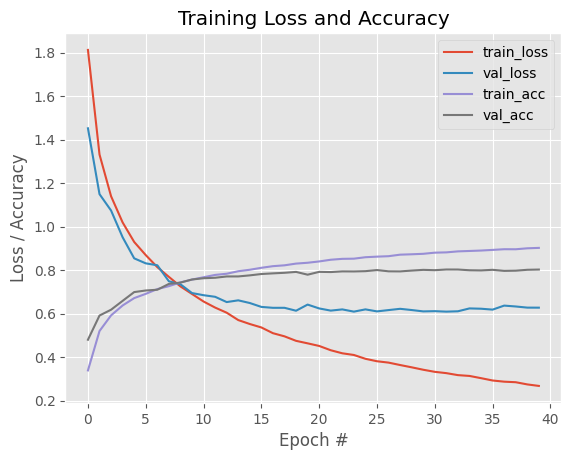

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epoch_num), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epoch_num), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()

In [10]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 54.0 MB/s eta 0:00:00


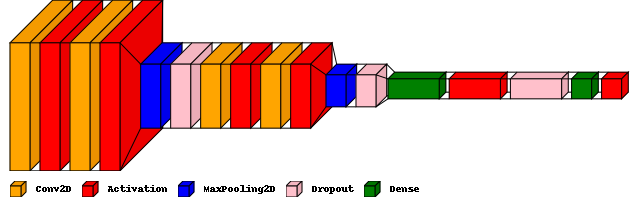

In [19]:
import visualkeras
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Activation]['fill'] = "red"
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'blue'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, color_map=color_map, legend=True, type_ignore=[Flatten])